# **Assignment: Statistics and Regression Review**
## Report for Debit Card Information Dataset
**Group 5, DS4A**  
Chris Andrei Irag • Ephraem Requilman • Joanna Reyda Santos • Kobe Marco Olaguir • Rod Vincent Dela Vega • Ruszed Jy Ayad  

---

In this notebook we explore the monthly debit card information dataset.  
We begin with a quick understanding of what the data represents, then perform both descriptive and inferential analyses. Finally, we check whether linear regression—using both sklearn and statsmodels—is a suitable model, and share our conclusions and recommendations.

## Setup

We begin by setting up our environment, ensuring required packages are installed both locally and in Colab.  

In [1]:
import os

from tqdm import tqdm


def in_colab() -> bool:
    """
    Check whether the current Python session is running in Google Colab.

    This function determines if the code is executed within a Google Colab
    environment by checking for the ``COLAB_RELEASE_TAG`` environment variable,
    which is automatically set by Colab runtimes.

    Returns
    -------
    bool
        ``True`` if running in Google Colab, ``False`` otherwise.

    Notes
    -----
    - This method relies on environment variables set by Colab.
    - It may not detect Colab if Google changes or removes the ``COLAB_RELEASE_TAG`` variable.
    - Alternative detection strategies include importing ``google.colab`` or inspecting the IPython shell.

    Examples
    --------
    >>> in_colab()
    False  # When run locally

    >>> in_colab()
    True   # When run inside Google Colab
    """
    return "COLAB_RELEASE_TAG" in os.environ

In [2]:
IN_COLAB: bool = in_colab()

if IN_COLAB:
    print("Installing packages...")

    packages = ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "statsmodels"]
    with tqdm(total=len(packages), desc="Installing packages", unit="package") as pbar:
        for package in packages:
            pbar.set_description(f"Installing {package}")
            os.system(f"pip install {package}")
            pbar.update(1)

    print("\nFinished installing. ✨")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if IN_COLAB:
    CMR10_STYLE = (
        "https://raw.githubusercontent.com/"
        "iragca/DS412-Time-Series-Analysis-and-Stochastic-Processes/"
        "refs/heads/master/src/matplotlib/iragca_cmr10.mplstyle"
    )
    plt.style.use(CMR10_STYLE)
else:
    from src.config import DirectoryPaths
    from src.matplotlib import Styles
    plt.style.use(Styles.CMR10.value)

2025-09-23 20:24:59.399 | INFO     | src.config:<module>:26 - Loaded environment variables from /home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.env
2025-09-23 20:24:59.400 | INFO     | src.config:<module>:49 - PROJECT_ROOT: /home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes
2025-09-23 20:24:59.400 | INFO     | src.config:<module>:50 - DATA_DIR: /home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/data
2025-09-23 20:24:59.401 | INFO     | src.matplotlib.color:<module>:103 - Accessible color palette inspired by https://github.com/mpetroff/accessible-color-cycles.


# About the Data

We believe that the data is about monthly debit cards insurance. We only now that it's temporal range is Jan 2000 - Aug 2013. The unit values are measured in *millions*.
It's temporal resolution is on a per month basis.

## Loading Data

We load the debit card dataset, which contains **164 monthly records (Jan 2000 – Aug 2013)**.  
The dataset has two columns:  

- **`Date`**: monthly time periods  
- **`Debit Cards`**: number of debit cards issued (in millions)  

In [4]:
def load_data(in_colab: bool) -> pd.DataFrame:
    """
    Load the debit cards dataset either from a remote GitHub URL (Colab)
    or from a local path (non-Colab).

    Parameters
    ----------
    in_colab : bool
        Flag indicating whether the function is running inside Google Colab.
        If True, loads the dataset from a remote GitHub repository.
        If False, loads the dataset from a local path defined in `src.config.DirectoryPaths`.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the debit cards dataset.
        - When `in_colab=True`, the index column is parsed as datetime (`date`).
        - When `in_colab=False`, the dataset is loaded from local storage.
        - If loading fails, an empty DataFrame is returned.

    Raises
    ------
    Exception
        Catches and prints any error during loading (e.g., file not found, network error),
        but does not raise the exception further.

    Notes
    -----
    - Remote dataset URL:
      `https://raw.githubusercontent.com/iragca/DS412-Time-Series-Analysis-and-Stochastic-Processes/refs/heads/master/data/external/debitcards.csv`
    - Local dataset path is determined by `DirectoryPaths.EXTERNAL_DATA`.

    Examples
    --------
    >>> # Load from GitHub (inside Colab)
    >>> df = load_data(in_colab=True)
    >>> df.head()

    >>> # Load from local path (outside Colab)
    >>> df = load_data(in_colab=False)
    >>> df.head()
    """

    try:
        if in_colab:
            DEBITCARDS_DATASET_URL = (
                "https://raw.githubusercontent.com/"
                "iragca/DS412-Time-Series-Analysis-and-Stochastic-Processes/"
                "refs/heads/master/data/external/debitcards.csv"
                )
            df = pd.read_csv(DEBITCARDS_DATASET_URL)
        else:

            DEBITCARDS_DATASET_PATH = DirectoryPaths.EXTERNAL_DATA.value / "debitcards.csv"
            df = pd.read_csv(DEBITCARDS_DATASET_PATH)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        df = pd.DataFrame()

    return df

In [5]:
df_raw = load_data(IN_COLAB)
df_raw.head()

,index,value
0,2000 Jan,7.204
1,2000 Feb,7.335
2,2000 Mar,7.812
3,2000 Apr,7.413
4,2000 May,9.136


In [6]:
df_raw.describe()

,value
count,164.000000
mean,15.828195
std,4.809113
min,7.204000
25%,11.654750
50%,16.336500
75%,19.231000
max,26.675000


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   164 non-null    object 
 1   value   164 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


## Preprocessing Data

To prepare the dataset, we:  
1. Rename columns for clarity  
2. Parse the `Date` into datetime format  
3. Reset the index for easier handling  

This gives us a clean time series from 2000–2013, ready for analysis.  

In [8]:
class Preprocessor:

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def __call__(self) -> pd.DataFrame:
        self.rename_columns()
        self.parse_dates()
        self.reset_index()
        return self.df

    def rename_columns(self) -> pd.DataFrame:
        columns = {
            "index": "Date",
            "value": "Debit Cards"
        }
        self.df.rename(columns=columns, inplace=True)
        return self.df

    def parse_dates(self) -> pd.DataFrame:
        self.df["Date"] = pd.to_datetime(self.df["Date"], format="%Y %b")
        self.df.set_index("Date", inplace=True)
        return self.df

    def reset_index(self) -> pd.DataFrame:
        self.df.reset_index(inplace=True)
        return self.df

In [9]:
preprocessor = Preprocessor(df_raw)
df = preprocessor()
df

,Date,Debit Cards
0,2000-01-01,7.204
1,2000-02-01,7.335
2,2000-03-01,7.812
3,2000-04-01,7.413
4,2000-05-01,9.136
...,...,...
159,2013-04-01,21.573
160,2013-05-01,23.685
161,2013-06-01,22.104
162,2013-07-01,25.340


## Descriptive Data Analysis

The descriptive statistics show debit card issuance ranging from about **7.2M to 26.7M**.  
The mean is ~15.8M, and the data exhibits a steady upward trend.  

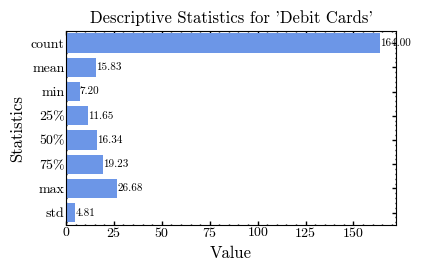

In [10]:
descriptive_df = df.describe()
sns.barplot(data=descriptive_df, y=descriptive_df.index, x="Debit Cards", orient="h")
plt.ylabel("Statistics")
plt.xlabel("Value")
plt.title("Descriptive Statistics for 'Debit Cards'")

# Plot every statistic value on the bars
for statistic in descriptive_df.index:
    plt.text(
        x=descriptive_df.loc[statistic, "Debit Cards"],
        y=statistic,
        s=f"{descriptive_df.loc[statistic, 'Debit Cards']:.2f}",
        va="center",
        ha="left",
        fontsize=8,
        color="black"
    )

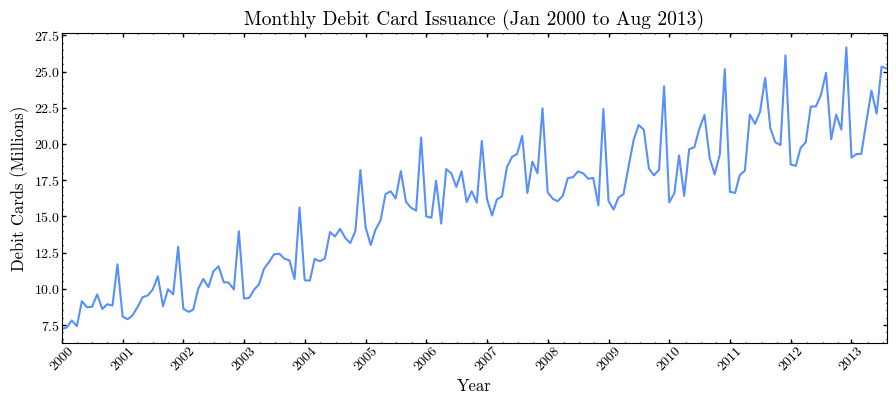

In [11]:
# Plot debit cards over time
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x="Date", y="Debit Cards")

# Title and axis labels
plt.title("Monthly Debit Card Issuance (Jan 2000 to Aug 2013)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Debit Cards (Millions)", fontsize=12)

# Format x-axis ticks: show every year, rotate for readability
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

# Set limits to dataset range
plt.xlim(df["Date"].min(), df["Date"].max())

plt.show()

Text(0, 0.5, 'Frequency')

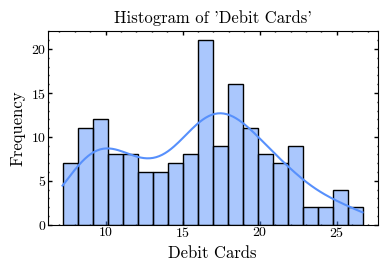

In [12]:
sns.histplot(data=df, x="Debit Cards", bins=20, kde=True)
plt.title("Histogram of 'Debit Cards'")
plt.ylabel("Frequency")

- The **line plot** highlights consistent growth over time, reflecting rising debit card adoption.
   - The data also shows clear seasonal patterns, with regular peaks and dips each year, likely tied to consumer spending cycles.  

- The **histogram** shows most values clustered between **15–25M**, confirming steady usage growth.  
  - No missing values are present, and the dataset appears clean and reliable.
  - The distribution shows a slight right tail. This suggests that while most months had moderate usage, there were some months with unusually high usage.  

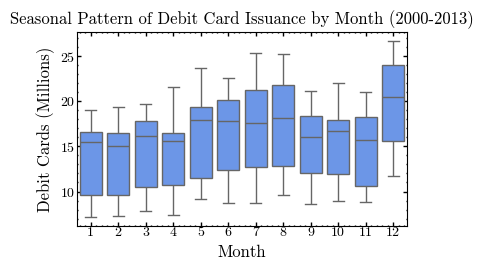

In [13]:
df['Month'] = df['Date'].dt.month

sns.boxplot(x='Month', y='Debit Cards', data=df)
plt.title("Seasonal Pattern of Debit Card Issuance by Month (2000-2013)")
plt.xlabel("Month")
plt.ylabel("Debit Cards (Millions)")
plt.show()

The **Seasonality Boxplot** shows debit card issuance fluctuates by season (e.g., **December spikes**).

## Inferential Data Analysis

In [14]:
# Create lag features for regression (lag-1 to lag-3 months)
df_lags = df.copy()
for lag in [1,2,3]:
    df_lags[f'lag_{lag}'] = df_lags['Debit Cards'].shift(lag)

df_lags = df_lags.dropna()

X = df_lags[['lag_1','lag_2','lag_3']]
y = df_lags['Debit Cards']

<Axes: title={'center': 'Lag Features Over Time'}, xlabel='Date', ylabel='Debit Cards (Millions)'>

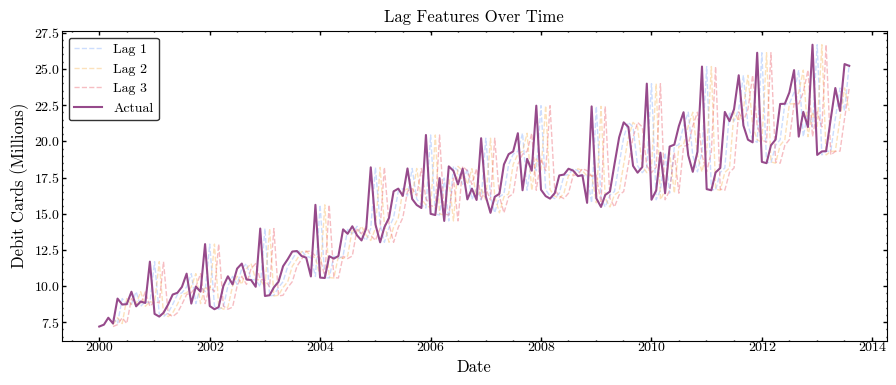

In [15]:
plt.figure(figsize=(10,4))
for lag in [1,2,3]:
    sns.lineplot(data=df_lags, x='Date', y=f'lag_{lag}', label=f'Lag {lag}', linestyle='--', linewidth=1, alpha=0.3)
    plt.title("Lag Features Over Time")
    plt.ylabel("Debit Cards (Millions)")
    plt.legend()

sns.lineplot(data=df, x='Date', y='Debit Cards', label='Actual')

In [16]:
from typing import Literal, Union


class Split:
    def __init__(self, split: pd.Series | np.ndarray, type: Literal["test", "train"]):
        self.split = split
        self.type = type
        self.size = len(split)
        self.index = split.index if isinstance(split, (pd.Series, pd.DataFrame)) else np.arange(len(split))

    def __len__(self) -> int:
        return len(self.split)

    def __getitem__(self, index: int) -> Union[pd.Series, np.ndarray]:
        if isinstance(self.split, (pd.Series, pd.DataFrame)):
            return self.split.iloc[index]  # row-based access
        elif isinstance(self.split, np.ndarray):
            return self.split[index]
        else:
            raise TypeError(f"Unsupported type: {type(self.split)}")

    def __iter__(self):
        return iter(self.split)

    def __array__(self, dtype=None, copy=None):
        """Allows np.array(Split(...)) to work."""
        return np.asarray(self.split, dtype=dtype, copy=copy)
    
    def __repr__(self):
        return self.split.__repr__()


def train_test_split(X: pd.DataFrame, y: pd.Series, train_size: float = 0.8):
    """
    Split features and target into training and testing sets while preserving time order.

    Parameters
    ----------
    X : pd.DataFrame
        Feature set.
    y : pd.Series
        Target variable.
    train_size : float, optional
        Proportion of data to use for training (default is 0.8).

    Returns
    -------
    X_train : pd.DataFrame
        Training features.
    X_test : pd.DataFrame
        Testing features.
    y_train : pd.Series
        Training target.
    y_test : pd.Series
        Testing target.

    Examples
    --------
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    """

    split_size = int(len(X) * train_size)
    X_train = Split(X.iloc[:split_size], "train")
    X_test = Split(X.iloc[split_size:], "test")
    y_train = Split(y.iloc[:split_size], "train")
    y_test = Split(y.iloc[split_size:], "test")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [17]:
class Results:

    def __init__(self, model, y_true: Split, y_pred: np.ndarray):
        self.model_name = model.__class__
        self.set = y_true.type
        self.y_true = y_true
        self.y_pred = y_pred
        self.mse = sk.metrics.mean_squared_error(y_true, y_pred)
        self.mae = sk.metrics.mean_absolute_error(y_true, y_pred)
        self.r2 = sk.metrics.r2_score(y_true, y_pred)

    def __repr__(self) -> str:
        return (f"{self.model_name} ({self.set.title()} set) Results:\n"
                f"MSE: {self.mse:.4f}\n"
                f"MAE: {self.mae:.4f}\n"
                f"R²: {self.r2:.4f}")

### Scikit-learn Implementation

In [18]:
# ---- Sklearn Linear Regression ----
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)

sklearn_train_results = Results(lr, y_train, y_train_pred)
sklearn_train_results

<class 'sklearn.linear_model._base.LinearRegression'> (Train set) Results:
MSE: 3.6454
MAE: 1.4866
R²: 0.7751

In [34]:
print("BIAS: ", lr.intercept_)
print("COEFFICIENTS: ", lr.coef_)

BIAS:  1.329947209892378
COEFFICIENTS:  [0.36507677 0.28050802 0.27368318]


#### Testing

In [19]:
y_pred = lr.predict(X_test)

sklearn_test_results = Results("Sklearn Linear Regression", y_test, y_pred)
sklearn_test_results

<class 'str'> (Test set) Results:
MSE: 9.1929
MAE: 2.6052
R²: -0.2697

<Axes: xlabel='Date', ylabel='Debit Cards'>

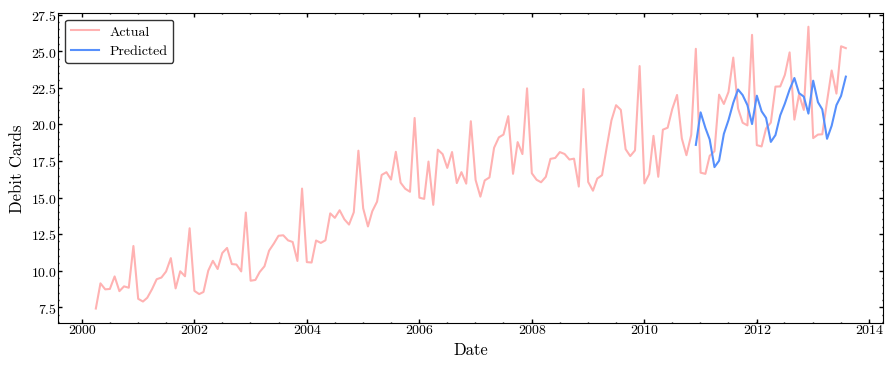

In [20]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df_lags, x='Date', y='Debit Cards', color='red', label='Actual', alpha=0.3)
sns.lineplot(x=df_lags["Date"][-y_test.size:], y=y_pred, label='Predicted')

### Statsmodels Implementation

In [21]:
X_sm = sm.add_constant(X_train)
ols_model = sm.OLS(np.array(y_train), X_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     142.4
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           5.32e-40
Time:                        20:25:01   Log-Likelihood:                -264.41
No. Observations:                 128   AIC:                             536.8
Df Residuals:                     124   BIC:                             548.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3299      0.663      2.005      0.0

In [33]:
print("BIAS: ", ols_model.params[0])
print("COEFFICIENTS: ", ols_model.params[1:])

BIAS:  1.329947209892392
COEFFICIENTS:  [0.36507677 0.28050802 0.27368318]


In [22]:
y_train_pred_sm = ols_model.predict(X_sm)
statsmodels_train_results = Results(ols_model, y_train, y_train_pred_sm)
statsmodels_train_results

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'> (Train set) Results:
MSE: 3.6454
MAE: 1.4866
R²: 0.7751

#### Testing

In [23]:
y_test_pred_sm = ols_model.predict(sm.add_constant(X_test))

statsmodels_test_results = Results(ols_model, y_test, y_test_pred_sm)
statsmodels_test_results

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'> (Test set) Results:
MSE: 9.1929
MAE: 2.6052
R²: -0.2697

<Axes: xlabel='Date', ylabel='Debit Cards'>

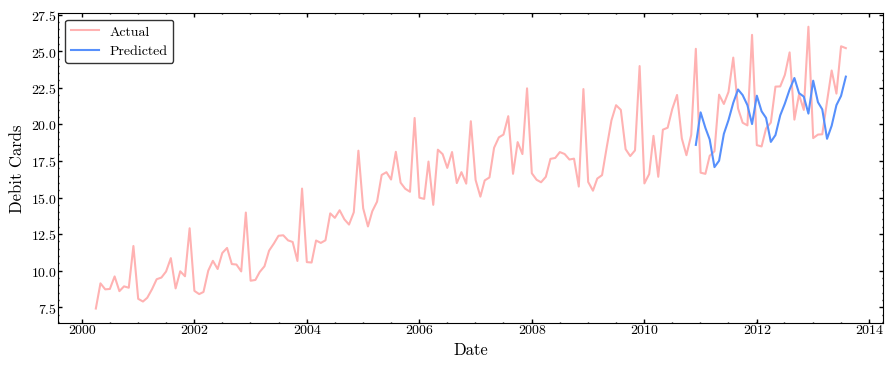

In [24]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df_lags, x='Date', y='Debit Cards', color='red', label='Actual', alpha=0.3)
sns.lineplot(x=df_lags["Date"][-y_test.size:], y=y_test_pred_sm, label='Predicted')

### Residuals

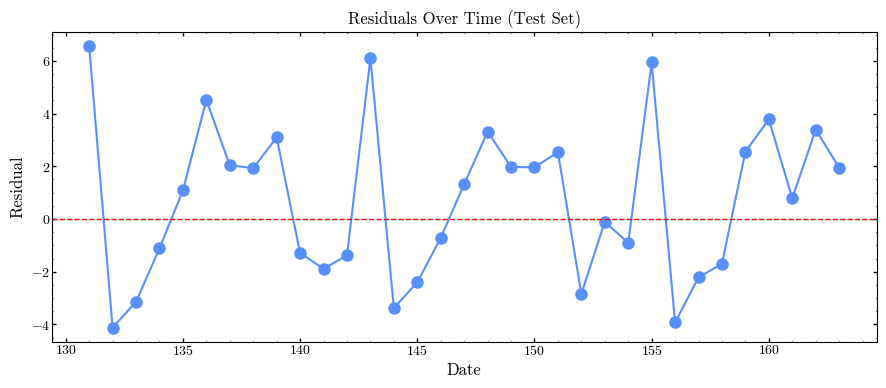

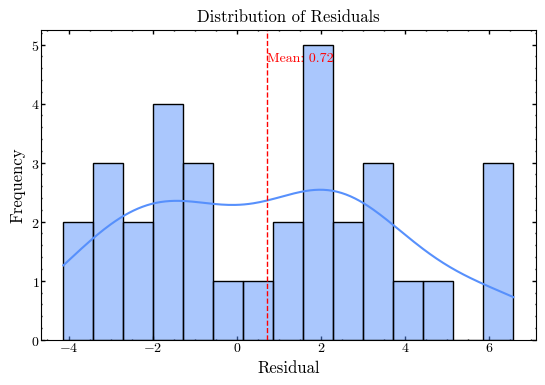

In [25]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals over time
plt.figure(figsize=(10,4))
plt.plot(y_test.index, residuals, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals Over Time (Test Set)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()

# Residual distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=15, kde=True)
plt.axvline(residuals.mean(), color='red', linestyle='--', linewidth=1)
plt.text(residuals.mean(), plt.ylim()[1]*0.9, f'Mean: {residuals.mean():.2f}', color='red')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

### Feature Importance

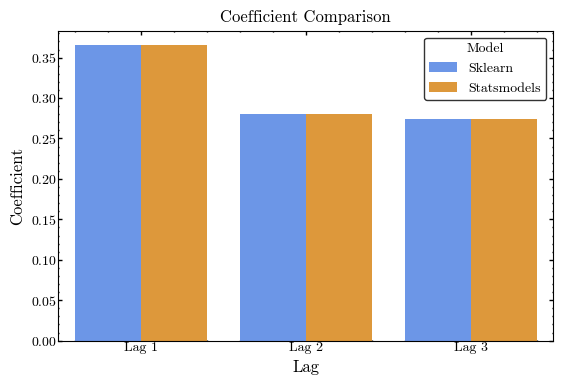

In [40]:
lags = ["Lag 1", "Lag 2", "Lag 3"]

df = pd.DataFrame({
    "Lag": lags * 2,
    "Coefficient": list(lr.coef_) + list(ols_model.params[1:]),
    "Model": ["Sklearn"] * len(lags) + ["Statsmodels"] * len(lags)
})

plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Lag", y="Coefficient", hue="Model")
plt.title("Coefficient Comparison")
plt.show()

Both models converged on the same of weights and biases. Lag 1, having the largest weight, presumably since it is only a day closer to the actual data, then Lag 2, and Lag 3 have lesser weights respectively.

**Interpretation**  
- The **sklearn model** struggled on the test set, showing a negative R². This means the lag-based linear regression did not generalize well out of sample.  
- The **statsmodels OLS model** and the **sklearn model** performed much the same, with R² ≈ -0.2697 on the test set, using a 80:20 split ratio.
- Both models converged on the same set of parameters.
- The **residual plots** show a bimodal distribution of residuals that are centered around zero (a mean of 0.72), but not perfectly random—there may be seasonality or nonlinear growth patterns not captured by linear regression.  
- Overall, linear regression gives useful insights, but time series–specific models (ARIMA, SARIMA, Prophet) would likely handle these patterns more effectively.  

## Conclusion

The **Debit Card dataset** shows a **steady upward trend** in monthly card issuance from **2000 to 2013**.  

- The **sklearn regression model** performed poorly on the test set, with a **negative R²**, showing weak out-of-sample prediction.  
- The **statsmodels OLS model** and the **sklearn model** approximately performed poorly the same, converging on the same set of weights and bias. 
- Overall, debit card growth is **strongly influenced by past values**, but **linear regression alone cannot fully capture long-term seasonality or nonlinear growth patterns**.  

## Takeaways & Recommendations

* **Steady growth**: Debit card issuance **consistently increased**, reflecting a broader **shift toward digital payment adoption**.  

* **Model insights**: Lag-based regression captures **short-term momentum**, but **time-series models** such as **ARIMA, SARIMA, or Prophet** would likely give **better forecasts**.  

* **Practical implications**: Banks and policymakers should **plan ahead for continued growth** by improving **infrastructure, fraud prevention systems, and customer education**.  

* **Future analysis**: Adding **external factors** (e.g., **population growth, economic indicators, technology adoption**) could make predictions **more accurate and insightful**.  